In [1]:
# import statements
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.io import loadmat

float_type = tf.float32

modelPath = './npde.ckpt/npode'
tbPath = './npde.summ'
# %matplotlib inline

from npde.utils import *
from npde.plotting import *
from npde.diffusions import SmoothODE, TimeInvariantBrownian
from npde.npde import NPODE, NPSDE
from npde.kernels import RBF, OperatorKernel

# tf.enable_eager_execution()
sess = tf.InteractiveSession()

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



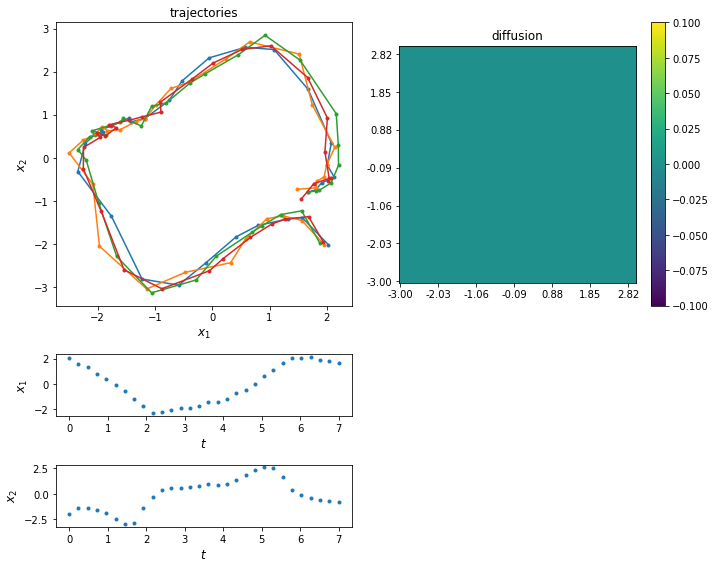

In [2]:
# van der pol data
Ny = [30,31,32,33]
Nt = 4
tend = 7
nstd = 0.1
x0 = np.asarray([[2.0,-2.0],[2.0,-2.0]],dtype=np.float32)
x0p,tp,Yp,X,ftrue,gtrue = gen_data('vdp',x0=x0,Ny=Ny,Nt=Nt,tend=tend,nstd=nstd)
D = 2
Yhighp = None
%matplotlib inline
plot_data(tp,Yp,ftrue,gtrue)

In [5]:
# npde initialization
sess.close()
tf.reset_default_graph()
sess = tf.InteractiveSession()

# params
ind_grid = True
W  = 5   # grid size
M  = 100 # total number of inducing points if there is no grid
Mt = 8   # number of time slices if spatio-temporal kronecker form 
sf0    = 1.0
ell0   = 1.25*np.ones(D) # 1.25
ellt0  = 1.0
sn0    = 0.1*np.ones(D)
ktype  = "id"
eta = 3e-3
whiten = True

# initialization
def init_U0(sess=None,Y=None,t=None,t0=None,kern=None,Z0=None,whiten=None):
    Ug = (Y[1:,:] - Y[:-1,:]) / np.reshape(t[1:]-t[:-1],(-1,1))
    if ktype == 'tid':
        t = np.reshape(t,[-1,1])
        Y = np.hstack((Y,t))
    tmp = NPODE(_,Z0=Y[:-1,:],U0=Ug,sn0=0,kern=kern,jitter=0.2,whiten=False,
                summ=False,fix_Z=True,fix_U=True,fix_Zt=True,fix_sn=True)
    U0 = tmp.f(X=Z0)
#     U0 = np.zeros_like(Z0,dtype=np.float32)
#     for i in range(U0.shape[0]):
#         U0[i,:] = vdp(Z0[i,:],t[i])
    if whiten:
        Lz = tf.cholesky( kern.K(Z0)+tf.eye(Mx)*1e-3 ) 
        U0 = tf.matrix_triangular_solve(Lz, U0, lower=True)
    sess.run(tf.global_variables_initializer())
    U0 = sess.run(U0)
    return U0
    
# create ind. points along space
if D==1:
    W = 10
    Mx = W
    Z0 = np.linspace(-4, 4, W).reshape((-1,1))
elif D==2:
    xv = np.linspace(np.min([np.min(Y[:,0]) for Y in Yp]), np.max([np.max(Y[:,0]) for Y in Yp]), W)
    yv = np.linspace(np.min([np.min(Y[:,1]) for Y in Yp]), np.max([np.max(Y[:,1]) for Y in Yp]), W)
#     xv = np.linspace(-3, 3, W)
#     yv = np.linspace(-3, 3, W)
    Mx = W*W
    xv,yv = np.meshgrid(xv,yv)
    Z0 = np.array([xv.T.flatten(),yv.T.flatten()]).T
else:
    if ind_grid:
        xv = np.linspace(np.min([np.min(Y[:,0]) for Y in Yp]), np.max([np.max(Y[:,0]) for Y in Yp]), W)
        yv = np.linspace(np.min([np.min(Y[:,1]) for Y in Yp]), np.max([np.max(Y[:,1]) for Y in Yp]), W)
        zv = np.linspace(np.min([np.min(Y[:,2]) for Y in Yp]), np.max([np.max(Y[:,2]) for Y in Yp]), W)
        Mx = W*W*W
        xv,yv,zv = np.meshgrid(xv,yv,zv)
        Z0 = np.array([xv.T.flatten(),yv.T.flatten(),zv.T.flatten()]).T
    else:
        Mx = M
        if ktype == "id":
            data_ = np.empty((0,D))
            for i in range(len(Yp)):
                data_ = np.concatenate((data_,Yp[i]))
            Z0 = kmeans2(data_, M, minit='points')[0]
            Z0 += ss.norm.rvs(size=Z0.shape)*0.0
        elif ktype == "tid":
            ell0 = np.hstack((ell0,ellt0))
            data_ = np.empty((0,D+1))
            Ys = []
            for i in range(len(Yp)):
                Ys.append(np.hstack((Yp[i],np.reshape(tp[i],[-1,1]))))
                data_ = np.concatenate((data_,Ys[i]))
            Z0 = kmeans2(data_, M, minit='points')[0]
#             Z0 += ss.norm.rvs(size=Z0.shape)*0.0
            
# for i in range(20):
#     dists = np.sum((Z0[1:,:-1]-Z0[:-1,:-1])**2,1)
#     amax = np.argmax(dists)
#     amin = np.argmin(dists)
#     Z0[amin,:] = (Z0[amax,:]+Z0[amax+1,:])/2
#     Z0 = Z0[np.argsort(Z0[:,-1]),:]
# plt.plot(dists)
    

# create ind. points along time
mxidx = 0
mxlen = -1
for i in range(len(tp)):
    if mxlen < len(tp[i]):
        mxlen = len(tp[i])
        mxidx = i
t0 = np.sort(kmeans2(tp[mxidx], Mt, minit='points')[0])

tmp_kern = OperatorKernel(sf0,ell0,ktype="id",fix_ell=True,fix_sf=True,fix_ellt=True)
if ktype == "id" or ktype == "tid":
    U0 = np.zeros((Mx,D),dtype=np.float32)
    for i in range(len(Yp)):
        U0 += init_U0(sess,Yp[i],tp[i],t0,tmp_kern,Z0,whiten)
    U0 /= len(Yp)
elif ktype == "kr":
    U0 = np.zeros((Mx*Mt,D))
    for t_ in range(Mt):
        U0t = np.zeros(Z0.shape,dtype=np.float32)
        for i in range(len(Yp)):
            U0t += init_U0(sess,Yp[i][t_*Mx:(t_+1)*Mx,:],
                                tp[i][t_*Mx:(t_+1)*Mx],t0,tmp_kern,Z0,whiten)
        U0[np.arange(t_*Mx,(t_+1)*Mx),:] = U0t / len(Yp)

lensp = [len(ti) for ti in tp]
dataset = DataSet(x0p,tp,Yp,lensp,Yhighp)
x0   = tf.placeholder(tf.float32,name='x0_placeholder')
t    = tf.placeholder(tf.float32,name='t_placeholder')
Y    = tf.placeholder(tf.float32,name='Y_placeholder')
lens = tf.placeholder(tf.int32,name='lens_placeholder')
Yhigh = tf.placeholder(tf.float32,name='Yhigh_placeholder')

Instructions for updating:
Colocations handled automatically by placer.


742.9508


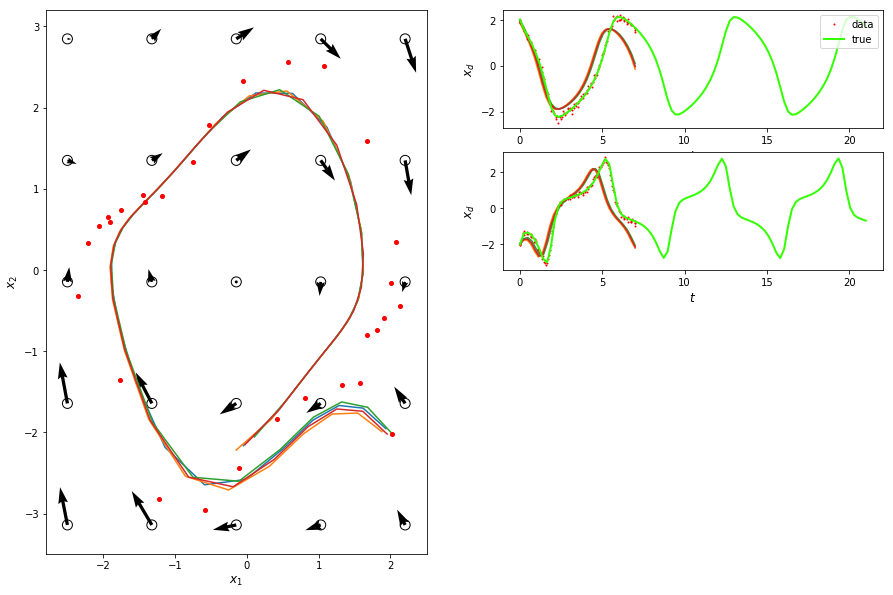

In [8]:
# npODE

# U0 += np.random.normal(0,1,(Mx,D))
# U0 = samples[0][2841]

kern = OperatorKernel(sf0=sf0,
                        ell0=ell0,
                        ktype="id",
                        learning_rate=eta,
                        summ=False,
                        fix_ell=True,
                        fix_sf=True,
                        fix_ellt=True)

npde = NPODE(dataset=dataset,
            Z0=Z0,
            U0=U0,
            sn0=sn0,
            kern=kern,
            learning_rate=eta,
            summ=False,
            whiten=whiten,
            fix_Z=True,
            fix_U=False,
            fix_sn=True,
            fix_Zt=True)

sess.run(tf.global_variables_initializer())

with tf.name_scope("cost"):
    Xs = npde.forward(t=t,x0=x0,lens=lens)
    def ll(x):
        Ny = x[2]
        X = tf.gather(x[0],tf.range(0,Ny),axis=0)
        Y = tf.gather(x[1],tf.range(0,Ny),axis=0)
        mvn = tfp.distributions.MultivariateNormalFullCovariance(
            loc=Y,covariance_matrix=tf.diag(npde.sn))
        ll = tf.reduce_sum(mvn.log_prob(X))
        return ll,ll,tf.constant([1])
    ll,_,_ = tf.map_fn(ll,(Xs,Y,lens),dtype=(tf.float32,tf.float32,tf.int32))
    ll = tf.reduce_sum(ll)
    ode_prior = npde.build_prior()
    cost = -(ll + ode_prior)

x0_,t_,Y_,lens_,Yhigh_ = dataset.next_batch(0)
dict_ = {x0:x0_, t:t_, Y:Y_, Yhigh:Yhigh_, lens:lens_}

print(cost.eval(feed_dict=dict_))
plot_model(npde,ftrue=ftrue)
    
def npde_post(sn,U,N=0):
    npde.sn = sn
    npde.U = U
    x0 = npde.dataset.x0t
    Y = npde.dataset.Yt
    t = npde.dataset.tt
    lens = npde.dataset.lenst
#     return -cost
    Xs = npde.forward(t=t,x0=x0,lens=lens)
    def ll(x):
        Ny = x[2]
        X = tf.gather(x[0],tf.range(0,Ny),axis=0)
        Y = tf.gather(x[1],tf.range(0,Ny),axis=0)
        mvn = tfp.distributions.MultivariateNormalFullCovariance(
            loc=Y,covariance_matrix=tf.diag(npde.sn))
        ll = tf.reduce_sum(mvn.log_prob(X))
        return ll,ll,tf.constant([1])
    ll,_,_ = tf.map_fn(ll,(Xs,Y,lens),dtype=(tf.float32,tf.float32,tf.int32))
    ll = tf.reduce_sum(ll)
    ode_prior = npde.build_prior()
    return ll + ode_prior

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

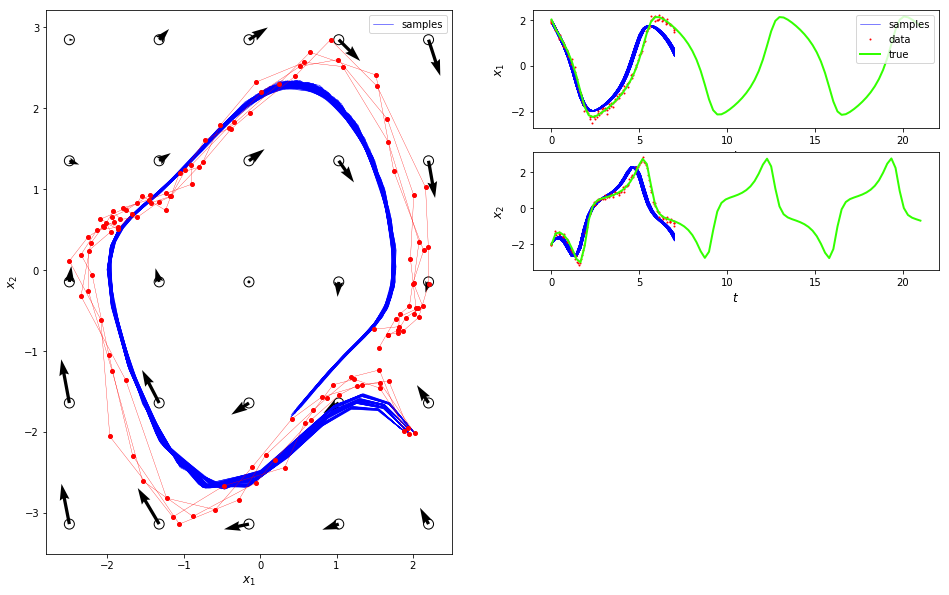

In [7]:
# npSDE
kern = OperatorKernel(sf0=sf0,
          ell0=ell0,
          ktype="id",
          learning_rate=eta,
          summ=False,
          fix_ell=True,
          fix_sf=True,
          fix_ellt=True)

# diffus = SmoothODE(sf0sig=1.0, ell0sig=[1e5],
#            sf0gp=0.1, ell0gp=0.1,
#            U0=np.ones([Z0.shape[0],1])*0.00, Z0=Z0,
#            D=D,
#            summ=False,
#            whiten=True,
#            jitter=1e-4,
#            fix_sfsig=True,fix_ellsig=True,
#            fix_sfgp=False,fix_ellgp=False,
#            fix_U=True,fix_Z=True)

diffus = TimeInvariantBrownian(sf0=1.0,
           ell0 = 1e5*np.ones(1,dtype=np.float32),
           U0 = np.ones([Z0.shape[0],1])*0.01,
           Z0 = Z0,
           whiten=True,
           fix_sf=True,
           fix_ell=True,
           fix_Z=True,
           fix_U=False)
    
npde = NPSDE(dataset=dataset,
              Z0=Z0,
              U0=U0,
              sn0=sn0,
              kern=kern,
              jitter=1e-5,
              diffus=diffus,
              learning_rate=eta,
              summ=False,
              whiten=whiten,
              fix_Z=True,
              fix_U=False,
              fix_sn=False,
              fix_Zt=True)

with tf.name_scope("npde-cost"):
    Xs = npde.forward(Nw=50,t=t,x0=x0,lens=lens)
    def ll(x):
        Ny = x[2]
        X = tf.gather(x[0],tf.range(0,Ny),axis=1)
        Y = tf.gather(x[1],tf.range(0,Ny),axis=0)
        mvn = tfp.distributions.MultivariateNormalFullCovariance(
            loc=Y,covariance_matrix=tf.diag(npde.sn))
        lls = tf.map_fn(lambda x: mvn.log_prob(x), X, dtype=tf.float32) # Nw x Ndata
        # ll = tf.reduce_sum(tf.log(tf.reduce_mean(tf.exp(lls),axis=0)))
        ll = tf.reduce_sum(logmeanexp(lls,axis=0))
        return ll,ll,tf.constant([1])
    ll,_,_ = tf.map_fn(ll,(Xs,Y,lens),dtype=(tf.float32,tf.float32,tf.int32))
    ll = tf.reduce_sum(ll)
    prior = npde.build_prior()
    cost = -(ll + prior)
    
def npde_post(sn,U,sf,ell,N=0):
    npde.sn = sn
    npde.U = U
    npde.diffus.kern_time.sf  = sf
    npde.diffus.kern_time.ell = ell
    x0 = npde.dataset.x0t
    Y = npde.dataset.Yt
    t = npde.dataset.tt
    lens = npde.dataset.lenst
    Xs = npde.forward(Nw=50,t=t,x0=x0,lens=lens)
    def ll(x):
        Ny = x[2]
        X = tf.gather(x[0],tf.range(0,Ny),axis=1)
        Y = tf.gather(x[1],tf.range(0,Ny),axis=0)
        mvn = tfp.distributions.MultivariateNormalFullCovariance(
            loc=Y,covariance_matrix=tf.diag(npde.sn))
        lls = tf.map_fn(lambda x: mvn.log_prob(x), X, dtype=tf.float32) # Nw x Ndata
        ll = tf.reduce_sum(tf.log(tf.reduce_mean(tf.exp(lls),axis=0)))
        return ll,ll,tf.constant([1])
    ll,_,_ = tf.map_fn(ll,(Xs,Y,lens),dtype=(tf.float32,tf.float32,tf.int32))
    ll = tf.reduce_sum(ll)
    prior = npde.build_prior()
    return ll + prior

sess.run(tf.global_variables_initializer())

x0_,t_,Y_,lens_,Yhigh_ = dataset.next_batch(0)
dict_ = {x0:x0_, t:t_, Y:Y_, lens:lens_}
print(cost.eval(feed_dict=dict_))

Xp = plot_model(npde,Nw=50,ftrue=ftrue)


# Xs = npde.forward(Nw=5)
# Xs = Xs[0].eval()
# plt.figure(figsize=(10,5))
# for j in range(3):
#     plt.plot(Xs[j,:])
# plt.title('Random draws, cost={:f}'.format(cost.eval()));

# Xs = [op.eval() for op in Xs]
# cost.eval()
# plt.figure(figsize=(10,10))
# for j in range(len(Xs)):
#     print(Xs[j].shape)
#     for i in range(Xs[j].shape[0]):
#         plt.plot(Xs[j][i,:,0],Xs[j][i,:,1],'.-',linewidth=1)


In [10]:
# prepare optimization
saver = tf.train.Saver()
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
expdec = tf.train.exponential_decay(1e-3,global_step,20,0.99,staircase=True)

optimizer = tf.train.AdamOptimizer(expdec).minimize(cost,global_step)

sess.run(tf.global_variables_initializer())
# sess.run(global_step.initializer)

all_var_list = tf.trainable_variables()
for i in all_var_list:
    print(i)
    
def variable_summaries():
    tf.summary.scalar('cost',cost)
    tf.summary.scalar('sf-f',npde.kern.sf)
    if 'gplvm' in globals():
        tf.summary.scalar('gplvm-beta',gplvm.beta)
        tf.summary.scalar('gplvm-sf',gplvm.kern.sf)
        for i in range(D):
            tf.summary.scalar('gplvm-ell-{:d}'.format(i+1),gplvm.kern.ell[i])
    for i in range(D):
        tf.summary.scalar('ell-f-{:d}'.format(i+1),npde.kern.ell[i])
        tf.summary.scalar('sn-{:d}'.format(i+1),npde.sn[i])
    if npde.name == 'npsde' and npde.diffus.name == 'smoothode':
        tf.summary.scalar('sf-g',npde.diffus.kern_time.sf)
        tf.summary.scalar('ell-g',npde.diffus.kern_time.ell)
        
variable_summaries()

merged = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(tbPath,graph=sess.graph)

Instructions for updating:
Use tf.cast instead.
<tf.Variable 'NPDE_4/U_1:0' shape=(25, 2) dtype=float32_ref>
<tf.Variable 'Brownian/U:0' shape=(25, 1) dtype=float32_ref>
<tf.Variable 'NPDE_5/sn:0' shape=(2,) dtype=float32_ref>
<tf.Variable 'NPDE_5/U_1:0' shape=(25, 2) dtype=float32_ref>
<tf.Variable 'NPDE_6/U_1:0' shape=(25, 2) dtype=float32_ref>


In [11]:
# run optimization

# saver.restore(sess,modelPath)
# tensorboard --logdir npde.summ
# python -m tensorboard.main --logdir npde.summ
# http://localhost:6006/

print('{:>16s}'.format("iteration")+'{:>16s}'.format("objective"))
num_iter = 100

# from gpflow import transforms
# transform=transforms.Log1pe()
# sess.run(all_var_list[4].assign(transform.backward(np.asarray([0.01,0.01]))))
# npde.sn = tf.constant(0.01*np.ones(3), dtype=np.float32)

t1 = time.time()
times = []
costs = []
cost_best = 1e4
for i in range(num_iter):
    x0_,t_,Y_,lens_,Yhigh_ = dataset.next_batch(0)
    dict_ = {x0:x0_, t:t_, Y:Y_, Yhigh:Yhigh_, lens:lens_}

    # batch = batch_gen.next()
    if i%5==0 or i==0 or i==num_iter-1:
#         saver.save(sess,modelPath)
#         npde.save('gsde50-simulated.pkl')
        cost_,_ = sess.run([cost,optimizer],feed_dict=dict_)
        merged = tf.summary.merge_all()
        summary = sess.run(merged,feed_dict=dict_)
        summary_writer.add_summary(summary,i)
        summary_writer.flush()
    else:
        cost_,_ = sess.run([cost,optimizer],feed_dict=dict_)
    print('{:>16d}'.format(i)+'{:>16.3f}'.format(cost_))
    costs.append(cost_)
    if cost_<cost_best:
        npde.save('golf_st_ode.pkl')
        cost_best = cost_
    times.append(time.time()-t1)
t2 = time.time()
print(t2-t1)

Xs = plot_model(npde,Nw=50,lp=cost_,ftrue=ftrue)

# save the data
# make sure that projection is consistent with how the data is read (mean centering, scaling, num. dims 50 or 62, etc)
# Xrec = np.matmul(np.matmul(Xs[0],np.diag(np.sqrt(v[:D]))),np.transpose(u[:,:D])) + means
# import scipy.io
# scipy.io.savemat('Xrec.mat',{'Y':Xrec,'initY':initY})

       iteration       objective
               0         742.951
               1         723.272
               2         703.825
               3         684.621
               4         665.672
               5         646.992
               6         628.591
               7         610.482
               8         592.674
               9         575.178
              10         558.003
              11         541.159
              12         524.652
              13         508.492
              14         492.683
              15         477.233
              16         462.146
              17         447.426
              18         433.078
              19         419.103
              20         405.505
              21         392.415
              22         379.697
              23         367.352
              24         355.379
              25         343.777
              26         332.545


KeyboardInterrupt: 

posterior:             332.54492


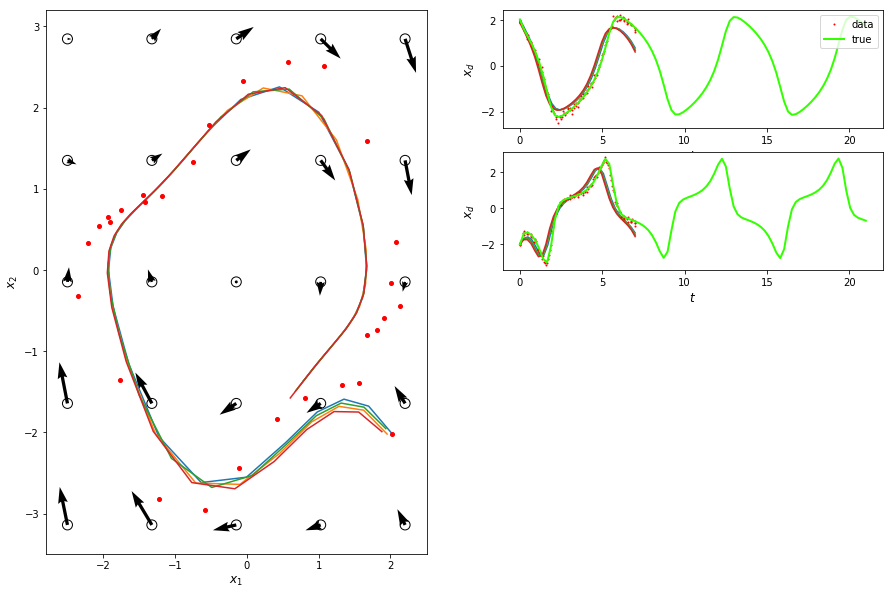

In [12]:
# plot model
%matplotlib inline
Xs = plot_model(npde,Nw=10,lp=cost_,ftrue=ftrue)

In [5]:
# Langevin and HAMCMC
post = -cost
x0_,t_,Y_,lens_,Yhigh_ = dataset.next_batch(0)
dict_ = {x0:x0_, t:t_, Y:Y_, Yhigh:Yhigh_, lens:lens_}
thetas = tf.trainable_variables()
grads = tf.gradients(post,thetas)
th_D = sum([tf.size(grad).eval() for grad in grads])

M = 2 # lbfgs memory
lamb = 0.1 # lbfgs constant
Slbfgs = np.zeros((M,th_D)) # stores parameters
Ylbfgs = np.zeros((M,th_D)) # stores grads

eta = 5e-5
Nsamp = 50

def get_th():
    return [t.eval() for t in thetas]

def set_th(new_th):
    for i,theta in enumerate(thetas):
        tf.assign(theta,new_th[i]).eval()
        
def get_post(feed_dict=dict_):
    return post.eval(feed_dict=feed_dict)

def get_new_post(new_th, feed_dict=dict_):
    old_th = get_th()
    set_th(new_th)
    post_ = get_post(feed_dict)
    set_th(old_th)
    return post_

def get_grad_vec(feed_dict=dict_):
    grad_vec = [sess.run(grad,feed_dict=dict_) for grad in grads]
    grad_vec = [grad.flatten() for grad in grad_vec]
    return np.array(grad_vec).flatten()

def get_th_vec():
    th_vec = [sess.run(th) for th in thetas]
    th_vec = [th.flatten() for th in th_vec]
    return np.array(th_vec).flatten()

def th_vec_to_arr(th_vec):
    th_arr = []
    iter_ = 0
    for i,theta in enumerate(thetas):
        th_shape = tf.shape(theta).eval()
        th_size = tf.size(theta).eval()
        th = th_vec[iter_:iter_+th_size]
        th_arr.append(np.reshape(th,th_shape))
        iter_ += th_size
    return th_arr

def set_th_vec(th_vec):
    iter_ = 0
    for i,theta in enumerate(thetas):
        th_size = tf.size(thetas[0]).eval()
        th = th_vec[iter_:iter_+th_size]
        tf.assign(theta,th).eval()
        iter_ += th_size
    
def init_sample_batches(Nsamp=Nsamp):
    thetas = tf.trainable_variables()
    for th in thetas:
        print(th)
    print()
    posts = np.zeros((Nsamp))
    samps = []
    for theta in thetas:
        th_shape = tf.shape(thetas[0]).eval()
        samps.append(np.zeros((Nsamp,th_shape[0],th_shape[1])))
    return posts,samps

def save_samples(epoch,post,thetas):
    posts[epoch] = post
    for i,theta in enumerate(thetas):
        samples[i][epoch] = theta
    
def lmc_new_th(eta=eta,feed_dict=dict_):
    new_th = []
    for i,theta in enumerate(thetas):
        new_th_i = theta + eta*grads[i] + tf.sqrt(2*eta)*tf.random_normal(tf.shape(theta))
        new_th_i = sess.run(new_th_i,dict_)
        new_th.append(new_th_i)
    return new_th

def inv_hessian():
    H = lamb * np.eye(th_D)
    if np.sum(np.abs(Slbfgs).sum(1)==0) > 0:
        return H
    for m in range(1,M):
        s = Slbfgs[m,:] - Slbfgs[m-1,:]
        y = Ylbfgs[m,:] - Ylbfgs[m-1,:]
        t1 = np.eye(th_D) - np.outer(s,y)/np.inner(s,y)
        t2 = np.eye(th_D) - np.outer(y,s)/np.inner(s,y)
        t3 = np.outer(s,s)/np.inner(y,y)
        if np.isnan(t1).sum() + np.isnan(t2).sum() + np.isnan(t3).sum() > 0:
            raise ValueError('Hessian contains NaN')
        H = np.matmul(np.matmul(t1,H),t2)+t3
    return H

def hamcmc_new_th(eta=eta,feed_dict=dict_):
    H  = inv_hessian()
    D  = H.shape[0]
    gr = get_grad_vec(feed_dict)
    th = get_th_vec()
    L  = np.linalg.cholesky(2*eta*H + np.eye(D)*1e-3)
    nu = np.matmul(L,np.random.normal(size=D))
    new_th_vec = th + eta*np.matmul(H,gr) + nu
    th_arr = th_vec_to_arr(new_th_vec) 
    return th_arr

def hamcmc_update_memory(feed_dict=dict_):
    gr = get_grad_vec(feed_dict)
    th = get_th_vec()
    Slbfgs[:-1,:] = Slbfgs[1:,:]
    Ylbfgs[:-1,:] = Ylbfgs[1:,:]
    Slbfgs[-1,:]  = th
    Ylbfgs[-1,:]  = gr

propose = hamcmc_new_th # lmc_new_th hamcmc_new_th

posts,samples = init_sample_batches(Nsamp)
old_post = get_post(dict_)
old_th = get_th()
save_samples(0,old_post,old_th)

for epoch in range(1,Nsamp):
    new_th = propose(feed_dict=dict_)
    new_post = get_new_post(new_th,dict_)
    u = np.random.rand()
    if np.log(u) < new_post-old_post:
        set_th(new_th)
        hamcmc_update_memory(dict_)
        old_post = new_post
        old_th = new_th
        action = 'accept'
    else:
        action = 'reject'
    save_samples(epoch,old_post,old_th)
    print('{:<8d}'.format(epoch)+'{:<8s}'.format(action)+'{:<16.3f}'.format(old_post))
    
print('completed')


/Users/yildizc1/work/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


<tf.Variable 'NPDE_4/U_1:0' shape=(25, 2) dtype=float32_ref>

1       accept  -801.666        
2       accept  -767.952        
3       accept  -554.025        
4       reject  -554.025        
5       reject  -554.025        
6       accept  -465.866        
7       reject  -465.866        
8       reject  -465.866        
9       reject  -465.866        
10      reject  -465.866        
11      reject  -465.866        
12      reject  -465.866        
13      reject  -465.866        


KeyboardInterrupt: 

/Users/yildizc1/work/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1c38076f60> has a label of '_line5' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Users/yildizc1/work/anaconda/lib/python3.5/site-packages/matplotlib/quiver.py:666: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/yildizc1/work/anaconda/lib/python3.5/site-packages/matplotlib/quiver.py:666: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/yildizc1/work/anaconda/lib/python3.5/site-packages/matplotlib/quiver.py:719: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/Users/yildizc1/work/anaconda/lib/python3.5/site-packages/matplotlib/quiver.py:733: RuntimeWarning: invalid value encountered in less
  tooshort = 

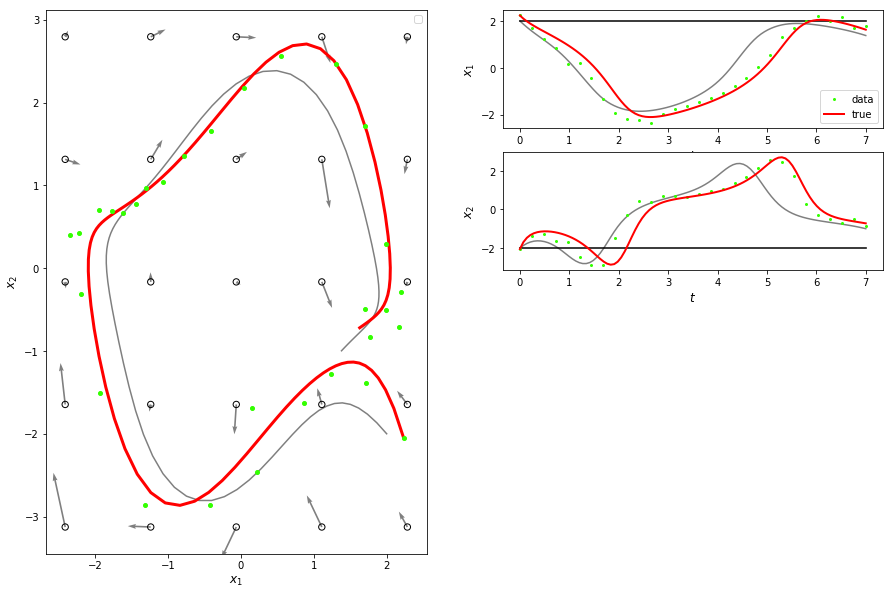

In [6]:
# plot sampled trajectories

t  = npde.dataset.t
Y  = npde.dataset.Y
Z = npde.Z.eval()
ts = np.linspace(0,7,100)

true_cycle = em_int(ftrue,lambda x,t:0,Y[0][0,:],ts)

ts = ts.reshape((1,-1))
t_ = tf.constant(ts,dtype=tf.float32)
x0_ = tf.constant([[2.,-2.]],dtype=tf.float32)
lens_ = tf.constant([np.size(ts)],dtype=tf.int32)

smp_idx = range(10,samples[0].shape[0],10) # thinning

Xp = []
Us = []
for i in smp_idx:
    tf.assign(npde.U,samples[0][i]).eval()
    Xp_i = npde.integrator.forward(t_,x0_,lens_).eval()
    Xp.append(np.squeeze(Xp_i))
    Us.append(samples[0][i])
    
plt.figure(1,figsize=(15,10))
gs = GridSpec(4, 2)
ax1 = plt.subplot(gs[0:4,0])
for i in range(len(Xp)):
    ax1.plot(Xp[i][:,0],Xp[i][:,1],'-k',alpha=0.5)
ax1.scatter(Z[:,0],Z[:,1],40, facecolors='none', edgecolors='k')
for i in range(len(Xp)):
    ax1.quiver(Z[:,0],Z[:,1],Us[i][:,0],Us[i][:,1],units='height',\
               width=0.003,color='k',alpha=0.5)
ax1.plot(true_cycle[:,0],true_cycle[:,1],'-r',linewidth=3,label='true')
pathh, = ax1.plot(Y[0][:,0],Y[0][:,1],'o',color='#33FF00',markersize=4)
handles_=[pathh]
ax1.set_xlabel('$x_1$', fontsize=12)
ax1.set_ylabel('$x_2$', fontsize=12)
ax1.legend(handles=handles_,loc=1)
for d in range(2):
    ax = plt.subplot(gs[d,1])
    for i in range(len(Xp)):
        ax.plot(ts[0],Xp[i][:,d],'-k',alpha=0.5)
    pathh, = ax.plot(t[0],Y[0][:,d],'o',color='#33FF00',markersize=2,label='data')
    handles_=[pathh]
    ax.set_xlabel('$t$', fontsize=12)
    trueh, = ax.plot(ts[0],true_cycle[:,d],'-r',linewidth=2,label='true')
    handles_.append(trueh)
    ax.set_ylabel('$x_{:d}$'.format(d+1), fontsize=12)
    if d==0:
        ax.legend(handles=handles_,loc=4)
plt.show()

In [13]:
# HMC or MALA
# there seems to be a tiny bug below
from tensorflow_probability.python.mcmc.util import maybe_call_fn_and_grads

initial_state = (npde.sn,npde.U)
log_prob_0, grad_0 = maybe_call_fn_and_grads(npde_post,initial_state)

# sampled variables are explicitly set below
print(tf.trainable_variables())
method = 'hmc' # 'hmc' 'mala'

if npde.name == 'npode':
    initial_state = (npde.sn,npde.U)
else:
    initial_state = (npde.sn,npde.U,npde.diffus.kern_time.sf,npde.diffus.kern_time.ell)

config = tf.ConfigProto()
sess = tf.Session(config = config)

time1 = time.time()

num_results = int(5e2)
num_burnin_steps = int(1)

sess.run(tf.global_variables_initializer())

if method == 'hmc':
    num_leapfrog_steps = 5
    step_size = 0.001
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn = npde_post,
                    step_size = step_size,
                    num_leapfrog_steps = num_leapfrog_steps)
elif method == 'mala':
    step_size = 0.0001
    kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=npde_post, step_size=step_size)

samples, kernel_results = tfp.mcmc.sample_chain(
        num_results = num_results,
        num_burnin_steps = num_burnin_steps,
        current_state = initial_state, 
        kernel = kernel)
samples_ = samples

samples = [sess.run(op) for op in samples]
Us = samples[1]
time2 = time.time()
print(time2-time1)

lp = sess.run(kernel_results.accepted_results.target_log_prob)

time2 = time.time()
print(time2-time1)
print(len(np.unique(lp)))


AttributeError: can't set attribute